In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import json

## Global Variables

In [198]:
start_year = 2013
end_year = 2016

climate_dir = "climate_timeseries/cleaned/"
vegetation_dir = "pandanwangi_timeseries/"
evi = True

In [178]:
# kecamatan_names = ['warungkondang', 'cibeber', 'campaka']
kecamatan_names = ['warungkondang']
# available_climate_datasets = ['POWER_warungkondang.csv', 'POWER_cibeber.csv']
# available_climate_datasets = ['era5_warungkondang.csv', 'era5_cibeber.csv', 'era5_campaka.csv']
# available_vegetation_datasets = ['warungkondang.csv', 'cibeber3.csv', 'campaka']
available_climate_datasets = ['chirts_warungkondang.csv']
available_vegetation_datasets = ['warungkondang.csv']

if evi:
    for i in range(len(available_vegetation_datasets)):
        available_vegetation_datasets[i] = 'evi_' + str(available_vegetation_datasets[i])
        
extract_statistics = ['mean', 'min', 'max', 'std']
statistic_corr = ['mean', 'min', 'max', 'std', 'smoothed_mean']

In [189]:
era5_features = [
        # Temperature variables
        'temperature_2m',                       # Air temperature
        'temperature_2m_min',                   # Daily minimum air temperature
        'temperature_2m_max',                   # Daily maximum air temperature
        'soil_temperature_level_1',             # Topsoil temperature (0-7 cm)
        'soil_temperature_level_2',             # Soil temperature (7-28 cm)
        
        # Moisture variables
        'volumetric_soil_water_layer_1',        # Topsoil moisture content
        'volumetric_soil_water_layer_2',        # Soil moisture (7-28 cm)
        'volumetric_soil_water_layer_3',        # Soil moisture (28-100 cm)
        'total_precipitation_sum',              # Total rainfall and snow
        'dewpoint_temperature_2m',              # Air humidity indicator
        
        # Radiation and energy variables
        'surface_solar_radiation_downwards_sum', # Solar radiation at surface
        'surface_net_solar_radiation_sum',       # Net solar radiation at surface
        
        # Evaporation and water cycle
        'total_evaporation_sum',                 # Actual evaporation
        
        # Wind variables
        'u_component_of_wind_10m',               # East-west wind component
        'v_component_of_wind_10m'                # North-south wind component
    ]

openweather_features = [
        'temp',         # Current temperature (C or K depending on units)
        'feels_like',   # Perceived temperature considering humidity and wind (C or K)
        'temp_min',     # Minimum temperature at the moment (C or K)
        'temp_max',     # Maximum temperature at the moment (C or K)
        'pressure',     # Atmospheric pressure at sea level (hPa)
        'humidity',     # Humidity percentage (%)
        'wind_speed',   # Wind speed (meter/sec)
        'wind_deg',     # Wind direction in degrees (0–360)
        'rain_1h',      # Rain volume for the last 1 hour (mm)
        'rain_3h',      # Rain volume for the last 3 hours (mm)
        'clouds_all'    # Cloudiness percentage (%)
    ]

chirts_features = [
        'heat_index',
        'maximum_temperature',
        'minimum_temperature',
        'relative_humidity',
        'saturation_vapor_pressure',
        'vapor_pressure_deficit',
    ]

power_features = [
        'T2M',           # MERRA-2 Temperature at 2 Meters (C)
        'T2MDEW',        # MERRA-2 Dew/Frost Point at 2 Meters (C)
        'T2MWET',        # MERRA-2 Wet Bulb Temperature at 2 Meters (C)
        'TS',            # MERRA-2 Earth Skin Temperature (C)
        'T2M_RANGE',     # MERRA-2 Temperature at 2 Meters Range (C)
        'T2M_MAX',       # MERRA-2 Temperature at 2 Meters Maximum (C)
        'T2M_MIN',       # MERRA-2 Temperature at 2 Meters Minimum (C)
        'PS',            # MERRA-2 Surface Pressure (kPa)
        'WS2M',          # MERRA-2 Wind Speed at 2 Meters (m/s)
        'WS2M_MAX',      # MERRA-2 Wind Speed at 2 Meters Maximum (m/s)
        'WS2M_MIN',      # MERRA-2 Wind Speed at 2 Meters Minimum (m/s)
        'GWETTOP',       # MERRA-2 Surface Soil Wetness (1)
        'GWETROOT'      # MERRA-2 Root Zone Soil Wetness (1)
    ]

## Global Functions

In [179]:
def difference_df(df):
    df = df.diff()
    return df

## Climate Datasets

In [180]:
# df_OpenWeather = pd.read_csv(f"{data_dir}/OpenWeather_pandanwangi.csv")
climate_df = {}
curr_kec = 0

try:
    for dataset in available_climate_datasets:
        curr = pd.read_csv(f"{climate_dir}/{dataset}")
        climate_df[kecamatan_names[curr_kec]] = curr
except:
    print(f"file kecamatan {kecamatan_names[curr_kec]} belum ada")

preprocessed_climate = {}

def climate_df_processing(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
    df.set_index('datetime', inplace=True)
    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]


for kec in kecamatan_names:
    preprocessed_climate[kec] = climate_df_processing(climate_df[kec])

print(preprocessed_climate[kecamatan_names[curr_kec]])

            heat_index  maximum_temperature  minimum_temperature  \
datetime                                                           
2013-01-01   74.554672            25.756230            20.747145   
2013-01-02   76.973567            27.762880            20.855382   
2013-01-03   76.893398            27.382159            21.158895   
2013-01-04   73.923767            25.751443            20.125785   
2013-01-05   74.680997            26.585456            20.157560   
...                ...                  ...                  ...   
2016-12-27   74.112240            26.441751            19.855736   
2016-12-28   76.922286            28.466051            20.171655   
2016-12-29   74.859193            26.849141            20.050328   
2016-12-30   74.515084            26.562989            19.959272   
2016-12-31   77.014065            28.359735            20.413020   

            relative_humidity  saturation_vapor_pressure  \
datetime                                               

## Vegetation Datasets

In [181]:
vegetation_df = {}

try:
    for i, dataset in enumerate(available_vegetation_datasets):
        curr = pd.read_csv(f"{vegetation_dir}/{dataset}")
        vegetation_df[kecamatan_names[i]] = curr
except:
    ""

In [182]:
print(vegetation_df['warungkondang']['label'].describe())

count                1393
unique                  2
top       non-pandanwangi
freq                  857
Name: label, dtype: object


In [183]:
preprocessed_vegetation = {}

def vegetation_preprocessing(df):
    df = df.iloc[:, 1:]
    df = df[df.label == 'pandanwangi']
    df = df.set_index('cluster_id')
    df = df.describe()
    df = df.T
    df = df[extract_statistics]
    indexes = df.index
    new_indexes = []
    for i in indexes:
        date = pd.to_datetime(i, format='%Y%m%d')
        new_indexes.append(date)
    df['datetime'] = new_indexes
    df = df.set_index('datetime')
    df = df.asfreq('5D', method='nearest')

    return df[(df.index.year >= start_year) & (df.index.year <= end_year)]

for kec in kecamatan_names:
    preprocessed_vegetation[kec] = vegetation_preprocessing(vegetation_df[kec])

In [184]:
smoothed_vegetation = {}

def smoothing_sg(df):
    filtered = savgol_filter(df['mean'], window_length=20, polyorder=3)
    df['smoothed_mean'] = filtered
    return df
    
for kec in kecamatan_names:
    smoothing_sg(preprocessed_vegetation[kec])

In [185]:
differenced_climate = {}
differenced_vegetation = {}

intersecting_indices = preprocessed_climate['warungkondang'].index.intersection(preprocessed_vegetation['warungkondang'].index)

for kec in kecamatan_names:
    differenced_climate[kec] = difference_df(preprocessed_climate[kec].loc[intersecting_indices]).iloc[1:, :]
    differenced_vegetation[kec] = difference_df(preprocessed_vegetation[kec]).loc[intersecting_indices].iloc[1:, :]

In [186]:
# differenced_climate['warungkondang'].head()

In [187]:
differenced_vegetation['warungkondang'].head()

,mean,min,max,std,smoothed_mean
datetime,,,,,
2013-01-06,0.0,0.0,0.0,0.0,0.000000e+00
2013-01-11,0.0,0.0,0.0,0.0,5.551115e-17
2013-01-16,0.0,0.0,0.0,0.0,0.000000e+00
2013-01-21,0.0,0.0,0.0,0.0,-5.551115e-17
2013-01-26,0.0,0.0,0.0,0.0,0.000000e+00


In [190]:
# json extract
correlation_indexes = {}

for kec in kecamatan_names:
    kec_vegetation = differenced_vegetation[kec]
    kec_climate = differenced_climate[kec]
    stat_dict = {}
    for statistic in extract_statistics:
        curr_stat = kec_vegetation[statistic]
        cuaca_dict = {}
        for faktor_cuaca in chirts_features:
            pearson = curr_stat.corr(kec_climate[faktor_cuaca], method='pearson')
            spearman = curr_stat.corr(kec_climate[faktor_cuaca], method='spearman')
            corr_dict = {
                'pearson': float(pearson),
                'spearman': float(pearson)
            }
            cuaca_dict[faktor_cuaca] = corr_dict
        stat_dict[statistic] = cuaca_dict
    correlation_indexes[kec] = stat_dict
            
# print(differenced_vegetation['warungkondang']['mean'].corr(differenced_climate['warungkondang']['temperature_2m'], method='pearson'))
# print(differenced_vegetation['warungkondang']['mean'].corr(differenced_climate['warungkondang']['soil_temperature_level_1'], method='pearson'))

In [192]:
# dataframe extract
correlation_indexes = {
    'kec': [],
    'statistic': [],
    'cuaca': [],
    'pearson': [],
    'spearman': []
}

for kec in kecamatan_names:
    kec_vegetation = differenced_vegetation[kec]
    kec_climate = differenced_climate[kec]
    stat_dict = {}
    for statistic in statistic_corr:
        curr_stat = kec_vegetation[statistic]
        cuaca_dict = {}
        for faktor_cuaca in chirts_features:
            pearson = curr_stat.corr(kec_climate[faktor_cuaca], method='pearson')
            spearman = curr_stat.corr(kec_climate[faktor_cuaca], method='spearman')
            correlation_indexes['pearson'].append(pearson)
            correlation_indexes['spearman'].append(spearman)
            correlation_indexes['cuaca'].append(faktor_cuaca)
            correlation_indexes['statistic'].append(statistic)
            correlation_indexes['kec'].append(kec)

In [193]:
# print(json.dumps(correlation_indexes, indent=2))
correlation_df = pd.DataFrame(correlation_indexes)

In [194]:
selected_kec = 'warungkondang'
kec_corr = correlation_df[correlation_df['kec'] == selected_kec]
kec_corr.sort_values("pearson", ascending=False).head(15)

,kec,statistic,cuaca,pearson,spearman
2,warungkondang,mean,minimum_temperature,0.097085,0.154954
8,warungkondang,min,minimum_temperature,0.073654,0.055952
14,warungkondang,max,minimum_temperature,0.054916,0.059941
3,warungkondang,mean,relative_humidity,0.047405,0.003408
9,warungkondang,min,relative_humidity,0.042898,0.007126
29,warungkondang,smoothed_mean,vapor_pressure_deficit,0.026390,0.000511
19,warungkondang,std,maximum_temperature,0.022991,0.027251
15,warungkondang,max,relative_humidity,0.018405,0.044963
25,warungkondang,smoothed_mean,maximum_temperature,0.017062,-0.001182
0,warungkondang,mean,heat_index,0.012331,0.075382


In [195]:
kec_corr.sort_values("pearson", ascending=True).head(15)

,kec,statistic,cuaca,pearson,spearman
5,warungkondang,mean,vapor_pressure_deficit,-0.040109,0.005141
11,warungkondang,min,vapor_pressure_deficit,-0.039648,-0.005846
1,warungkondang,mean,maximum_temperature,-0.038653,-0.008648
20,warungkondang,std,minimum_temperature,-0.035015,0.023435
13,warungkondang,max,maximum_temperature,-0.032797,-0.082693
7,warungkondang,min,maximum_temperature,-0.030330,-0.006286
27,warungkondang,smoothed_mean,relative_humidity,-0.029475,0.004077
26,warungkondang,smoothed_mean,minimum_temperature,-0.022608,-0.015364
17,warungkondang,max,vapor_pressure_deficit,-0.017774,-0.052093
16,warungkondang,max,saturation_vapor_pressure,-0.012515,-0.052553


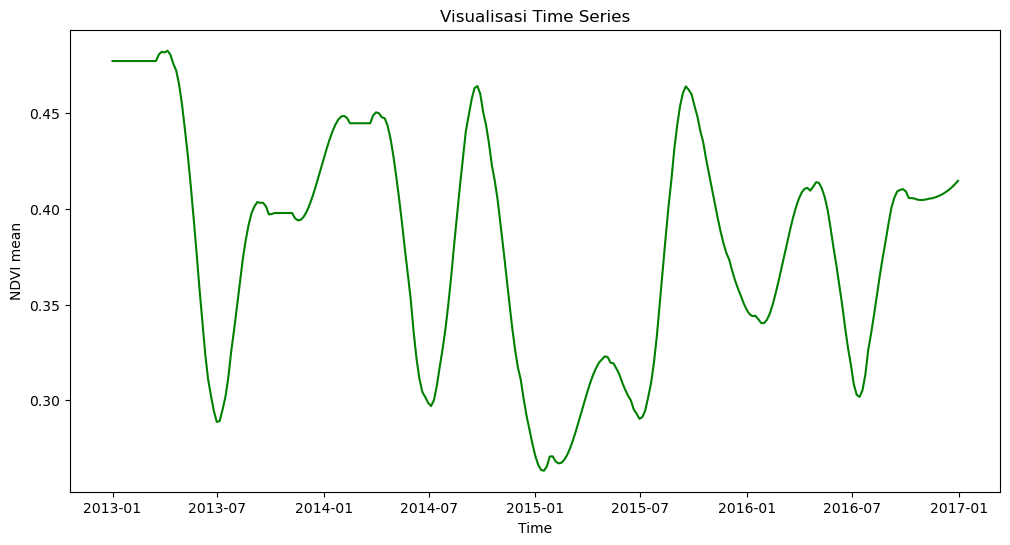

In [196]:
ts_df = preprocessed_vegetation['warungkondang']

# for stat in statistic:
plt.figure(figsize=(12, 6))
plt.plot(ts_df.index, ts_df['smoothed_mean'], label='NDVI mean', color='green')
plt.title(f'Visualisasi Time Series')
plt.xlabel('Time')
plt.ylabel('NDVI mean')
plt.show()

In [197]:
climate_ts = preprocessed_climate['warungkondang']

plt.figure(figsize=(12, 6))
plt.plot(climate_ts.index, climate_ts['temperature_2m'], label='temperature_2m', color='orange')
plt.title(f'Visualisasi Time Series')
plt.xlabel('Time')
plt.ylabel('Temperature mean')
plt.show()

KeyError: 'temperature_2m'

<Figure size 1200x600 with 0 Axes>

In [41]:
diff_df

datetime
2020-01-15    0.000000
2020-01-17    0.000000
2020-01-20    0.000000
2020-01-25    0.000000
2020-03-05    0.036384
                ...   
2024-11-11   -0.048570
2024-11-14   -0.000155
2024-11-19    0.004608
2024-11-24    0.000000
2024-11-27    0.000000
Name: mean, Length: 423, dtype: float64